https://iter01.com/565567.html
https://hackmd.io/@lido2370/S1aX6e1nN?type=view
https://www.kaggle.com/code/pinocookie/pytorch-simple-mlp/notebook
https://medium.com/jimmyfu87/cnn%E5%AF%A6%E4%BD%9Ckaggle%E8%B2%93%E7%8B%97%E5%BD%B1%E5%83%8F%E8%BE%A8%E8%AD%98-pytorch-26380b357a3d


In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
import torchvision
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
import openpyxl
from openpyxl.styles import Font
import os
from scipy.signal import argrelextrema
from sklearn.metrics import confusion_matrix,mean_squared_error
import seaborn as sn
from math import dist

In [ ]:
coordinate = [[1, 1], [1, 2], [1, 3], [1, 4], [1, 5], [1, 6], [1, 7], [1, 8], [1, 9], [1, 10], [6, 1], [6, 2], [6, 3], [6, 4], [6, 5], [6, 6], [6, 7], [6, 8], [6, 9], [6, 10], [11, 1], [11, 2], [11, 3], [11, 4], [11, 5], [11, 6], [11, 7], [11, 8], [11, 9], [11, 10], [1, 11], [2, 11], [3, 11], [4, 11], [5, 11], [6, 11], [7, 11], [8, 11], [9, 11], [10, 11], [11, 11]]
class MyDataset(Dataset):
    def __init__(self, csv):
        self.data = pd.read_csv(csv)
        self.size = len(self.data)
        # print(self.size)

    def __getitem__(self, index):
        row = self.data.loc[index]
        rssi = row.iloc[1:8].values #.astype(np.float32)
        # label = torch.tensor(area[int(row.iloc[0]) - 1], dtype=torch.float) # 從0開始
        label = torch.tensor(int(row.iloc[0]) - 1, dtype=torch.float) # 從0開始
        # print(rssi)
        rssi = torch.tensor(rssi, dtype=torch.float)
        return rssi, label

    def __len__(self):
        return self.size

In [ ]:
# split data
# set testing data size
valid_split = 0.2
# need shuffle or not
shuffle_dataset = True
# random seed of shuffle
random_seed = 2023
batch_size = 32

# creat data indices for training and testing splits
dataset = MyDataset('/content/drive/MyDrive/paper/wireless/1,-1/wireless_training_set_beacon.csv')
dataset_size = len(dataset)
indices = list(range(dataset_size))

# count out split size
split = int(np.floor(valid_split * dataset_size))
if shuffle_dataset:
    np.random.seed(random_seed)
    np.random.shuffle(indices)
train_indices, valid_indices = indices[split:], indices[:split]

# creating data samplers and loaders:
train_sampler = SubsetRandomSampler(train_indices)
valid_sampler = SubsetRandomSampler(valid_indices)

train_loader = DataLoader(dataset, batch_size=batch_size, sampler=train_sampler)
valid_loader = DataLoader(dataset, batch_size=batch_size, sampler=valid_sampler)

In [ ]:
class MLP(torch.nn.Module):
    def __init__(self, D_in, H, D_out):
        super(MLP, self).__init__()
        self.layer1 = nn.Linear(D_in, H)
        self.layer2 = nn.Linear(H, D_out)

    def forward(self, x):
        x = F.relu(self.layer1(x))
        x = F.dropout(x, 0.3)
        x = self.layer2(x)
        return x

    def init_weight(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                torch.nn.init.normal_(m.weight.data) # 使值服從常態分佈N(mean, std)，默認值為0，1
                m.bias.data.zero_() # 將bias初始化為0

In [ ]:
N = len(dataset) # 訓練資料數量
D_in = 7 # 訓練資料維度，也是輸入層神經元個數
H = 1024 # 隱藏層神經元個數
D_out = 41 # 輸出層神經元個數，也是訓練資料標籤的維度

In [ ]:
# model
model = MLP(D_in, H, D_out)
# loss
criterion = nn.CrossEntropyLoss()
# loss_fn = nn.MSELoss(reduction = 'sum')
# optimizer
learning_rate = 0.01
epochs = 200
optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9, weight_decay=0.0001)
classes = 41
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor = 0.1, patience=5)

In [ ]:
# training process
train_acc_his, valid_acc_his = [], []
train_losses_his, valid_losses_his = [], []
target_count = np.zeros(41)
for epoch in range(1, epochs + 1):
    # keep track of training and validation loss
    train_loss, valid_loss = 0.0, 0.0
    train_losses, valid_losses = [], []
    train_correct, val_correct, train_total, val_total = 0, 0, 0, 0
    train_pred, train_target = torch.zeros(batch_size,1), torch.zeros(batch_size,1)
    val_pred, val_target = torch.zeros(batch_size,1), torch.zeros(batch_size,1)
    count = 0
    count2 = 0
    print('running epoch: {}'.format(epoch))
    ###################
    # train the model #
    ###################
    model.train()
    for data, target in train_loader:
        # move tensors to GPU if CUDA is available
        target = target.type(torch.LongTensor)
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the batch loss
        loss = criterion(output, target)
        # calculate accuracy
        pred = output.data.max(dim = 1, keepdim = True)[1] # predict label, dtype = torch.int64
        train_correct += np.sum(np.squeeze(pred.eq(target.data.view_as(pred))).cpu().numpy()) # 若預測的答案和target相同，correct就累加
        train_total += data.size(0) # bache size
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()
        # update training loss
        train_losses.append(loss.item()*data.size(0))
        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        if count == 0:
            train_pred = pred
            train_target = target.data.view_as(pred)
            count = count + 1
        else:
            train_pred = torch.cat((train_pred,pred), 0)
            train_target = torch.cat((train_target,target.data.view_as(pred)), 0)
    train_pred = train_pred.cpu().view(-1).numpy().tolist()
    train_target = train_target.cpu().view(-1).numpy().tolist()

    ######################
    # validate the model #
    ######################
    model.eval()
    for data, target in valid_loader:
        # move tensors to GPU if CUDA is available
        target = target.type(torch.LongTensor)
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the batch loss
        loss = criterion(output, target)
        #calculate accuracy
        pred = output.data.max(dim = 1, keepdim = True)[1]
        val_correct += np.sum(np.squeeze(pred.eq(target.data.view_as(pred))).cpu().numpy())
        val_total += data.size(0)
        valid_losses.append(loss.item()*data.size(0))
        for i in range(len(target)):
            # print(target[i].item(), np.squeeze(pred)[i].item())
            target_count[target[i].item()] += 1
        if count2 == 0:
            val_pred = pred
            val_target = target.data.view_as(pred)
            count2 = count2 + 1
        else:
            val_pred = torch.cat((val_pred,pred), 0)
            val_target = torch.cat((val_target,target.data.view_as(pred)), 0)
    val_pred=val_pred.cpu().view(-1).numpy().tolist()
    val_target=val_target.cpu().view(-1).numpy().tolist()

    # calculate average losses
    train_loss=np.average(train_losses)
    valid_loss=np.average(valid_losses)
    scheduler.step(train_loss)

    # calculate average accuracy
    train_acc=train_correct/train_total
    valid_acc=val_correct/val_total


    train_acc_his.append(train_acc)
    valid_acc_his.append(valid_acc)
    train_losses_his.append(train_loss)
    valid_losses_his.append(valid_loss)

    # print training/validation statistics
    print('\tTraining Loss: {:.4f} \tValidation Loss: {:.4f}'.format(
        train_loss, valid_loss))
    print('\tTraining Accuracy: {:.4f} \tValidation Accuracy: {:.4f}'.format(
        train_acc, valid_acc))
    # print(target_count)

running epoch: 1
	Training Loss: 102.1266 	Validation Loss: 83.8742
	Training Accuracy: 0.1582 	Validation Accuracy: 0.2407
running epoch: 2
	Training Loss: 78.3504 	Validation Loss: 69.1353
	Training Accuracy: 0.3242 	Validation Accuracy: 0.3913
running epoch: 3
	Training Loss: 67.2728 	Validation Loss: 62.6204
	Training Accuracy: 0.4110 	Validation Accuracy: 0.3602
running epoch: 4
	Training Loss: 61.0389 	Validation Loss: 58.2129
	Training Accuracy: 0.4502 	Validation Accuracy: 0.4068
running epoch: 5
	Training Loss: 57.1326 	Validation Loss: 53.8476
	Training Accuracy: 0.4777 	Validation Accuracy: 0.4720
running epoch: 6
	Training Loss: 54.0664 	Validation Loss: 52.4702
	Training Accuracy: 0.4824 	Validation Accuracy: 0.4953
running epoch: 7
	Training Loss: 51.6666 	Validation Loss: 50.5068
	Training Accuracy: 0.5087 	Validation Accuracy: 0.4736
running epoch: 8
	Training Loss: 49.8717 	Validation Loss: 49.3027
	Training Accuracy: 0.5064 	Validation Accuracy: 0.4876
running epoch: 

In [ ]:
# save model

from datetime import datetime,timezone,timedelta
dt1 = datetime.utcnow().replace(tzinfo=timezone.utc)
dt2 = dt1.astimezone(timezone(timedelta(hours=8))) # 轉換時區 -> 東八區
current_time = dt2.strftime("%Y-%m-%d %H:%M:%S")

save_model_name = '/content/drive/MyDrive/paper/wireless/mlp_model/mlp_model_41_' + current_time + '.pt'
torch.save(model, save_model_name)

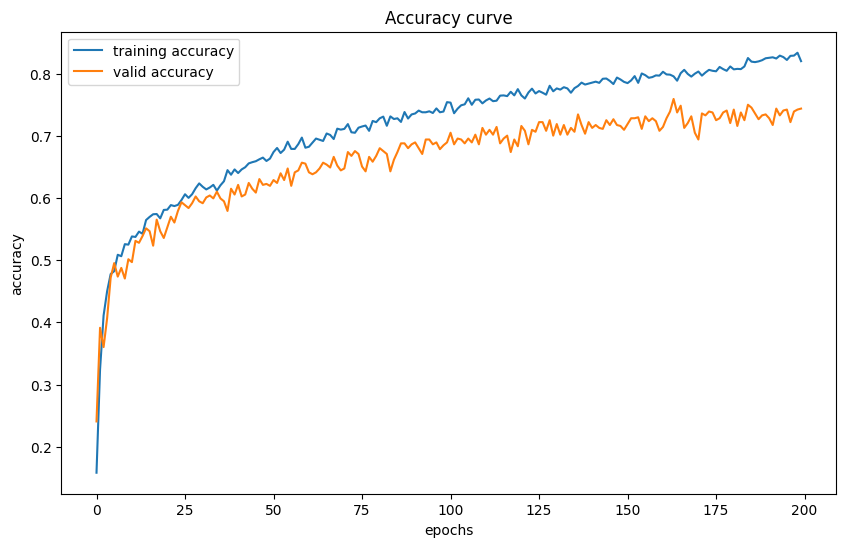

In [ ]:
plt.figure(figsize=(10,6))
plt.plot(train_acc_his, label='training accuracy')
plt.plot(valid_acc_his, label='valid accuracy')
plt.title('Accuracy curve')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()
plt.show()

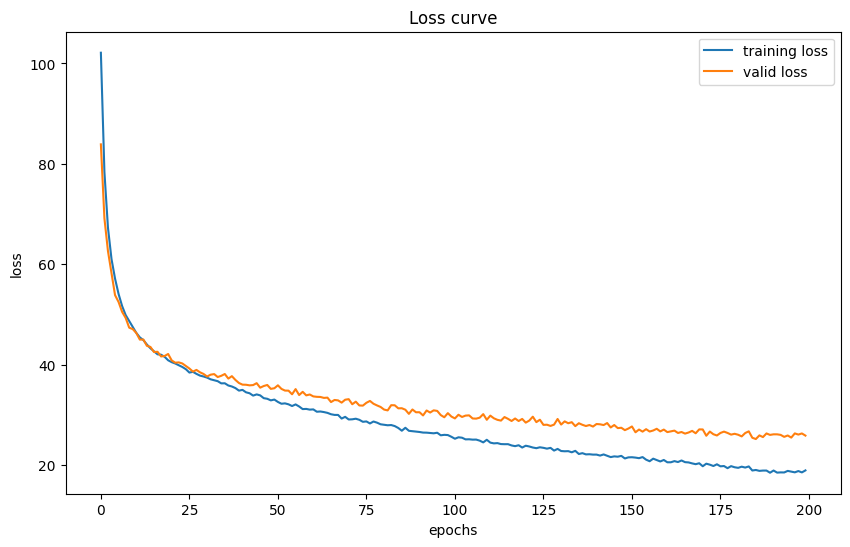

In [ ]:
plt.figure(figsize=(10,6))
plt.plot(train_losses_his, label='training loss')
plt.plot(valid_losses_his, label='valid loss')
plt.title('Loss curve')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()
plt.show()

In [ ]:
def ConfusionMatrix(y_true, y_pred):
    cm = confusion_matrix(y_true , y_pred)
    fit = plt.figure(figsize=(8,6))
    plt.title('Confusion Matrix')
    sn.heatmap(cm,annot=True,cmap='OrRd',fmt='g')
    plt.xlabel('Prediction')
    plt.ylabel('Ground Truth')
    plt.show()

In [ ]:
def test(file, test_model, print_target):
  testset = MyDataset(file)
  testset_size = len(testset)
  test_indices = list(range(testset_size))

  # creating data samplers and loaders:
  test_loader = DataLoader(testset, batch_size=batch_size, shuffle=False)

  test_loss = 0.0
  test_losses = []
  test_correct, test_total = 0, 0
  test_pred = torch.zeros(batch_size,1)
  test_target = torch.zeros(batch_size,1)
  count = 0
  test_acc_his, test_losses_his = [], []
  dis_error = 0

  test_model.eval()
  target_count = np.zeros(41)
  with torch.no_grad():  # 關閉梯度計算
      for data, target in test_loader:
          # move tensors to GPU if CUDA is available
          target = target.type(torch.LongTensor)
          # forward pass: compute predicted outputs by passing inputs to the model
          output = test_model(data)
          # calculate the batch loss
          loss = criterion(output, target)
          #calculate accuracy
          pred = output.data.max(dim = 1, keepdim = True)[1]
          test_correct += np.sum(np.squeeze(pred.eq(target.data.view_as(pred))).cpu().numpy())
          test_total += data.size(0)

          test_losses.append(loss.item()*data.size(0))
          # print(target)
          for i in range(len(target)):
            if(len(target) > 1):
              dis_error += dist(coordinate[target[i].item()] ,coordinate[np.squeeze(pred)[i].item()])
              if print_target:
                print(np.squeeze(pred)[i].item() + 1, target[i].item() + 1)
            else:
              dis_error += dist(coordinate[target[i].item()] ,coordinate[np.squeeze(pred).item()])
              if print_target:
                print(np.squeeze(pred).item() + 1, target[i].item() + 1)
            # print(target[i].item(), np.squeeze(pred)[i].item())
            target_count[target[i].item()] += 1
            #pre_sheet.cell(target[i].item() + 2, np.squeeze(pred)[i].item() + 2).value += 1
          if count == 0:
              test_pred = pred
              test_target = target.data.view_as(pred)
              count = count + 1
          else:
              test_pred = torch.cat((test_pred,pred), 0)
              test_target = torch.cat((test_target,target.data.view_as(pred)), 0)
  test_pred=test_pred.cpu().view(-1).numpy().tolist()
  test_target=test_target.cpu().view(-1).numpy().tolist()

  # calculate average losses
  test_loss=np.average(test_losses)

  # calculate average accuracy
  test_acc=test_correct/test_total

  test_acc_his.append(test_acc)
  test_losses_his.append(test_loss)

  dis_error = dis_error/test_total
  print('Mean Distance Error:', dis_error * 0.6)

  # print training/validation statistics
  print('Testing Loss: {:.4f}'.format(
      test_loss))
  print('Testing Accuracy: {:.4f}'.format(
      test_acc))

  ConfusionMatrix(test_target, test_pred)
  print(target_count)

In [ ]:
#test_model = torch.load('/content/drive/MyDrive/paper/wireless/mlp_model/mlp_model_41_2023-04-25 23:45:02.pt')
test_model = model

Mean Distance Error: 1.3389335237677302
Testing Loss: 111.0107
Testing Accuracy: 0.2286


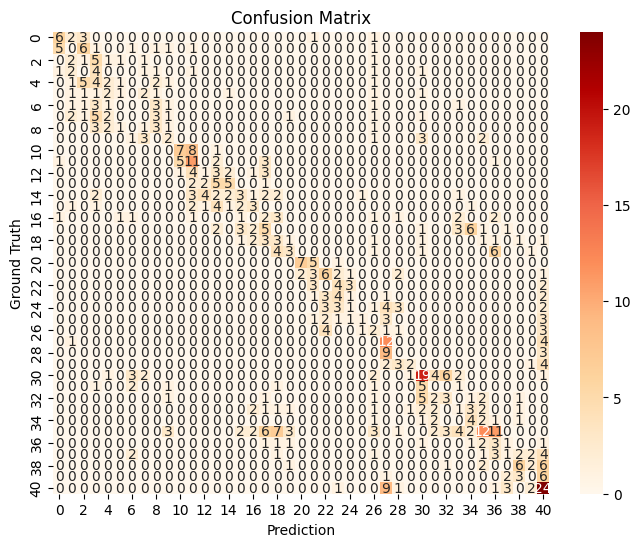

[13. 17. 12. 12. 17. 12. 12. 17. 12. 12. 16. 23. 15. 15. 23. 16. 16. 24.
 16. 16. 13. 17. 12. 12. 17. 12. 12. 17. 12. 12. 41. 12. 17. 18. 12. 61.
 12. 17. 18. 12. 41.]


In [ ]:
test('/content/drive/MyDrive/paper/wireless/1,-1/new_beacon_GalaxyA51.csv', test_model, 0)

Mean Distance Error: 1.2025202667630606
Testing Loss: 99.8439
Testing Accuracy: 0.2596


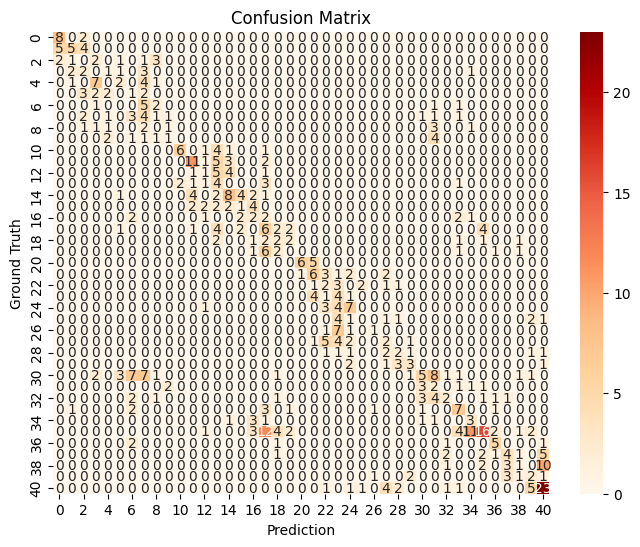

[10. 14. 10. 10. 15. 10. 10. 15. 10. 10. 13. 22. 12. 12. 22. 13. 12. 22.
 12. 12. 11. 15. 10. 10. 15. 10. 10. 15. 10. 10. 39. 10. 16. 17. 10. 58.
 10. 16. 17. 10. 39.]


In [ ]:
test('/content/drive/MyDrive/paper/wireless/1,-1/old_beacon_GalaxyA51.csv', test_model, 0)

26 23
41 27
41 40
41 36
18 16
18 12
11 12
13 17
18 35
31 31
8 7
3 2
2 1
12 5
7 10
31 31
10 31
10 9
5 4
1 1
1 1
1 4
6 9
31 32
33 20
35 15
14 11
11 11
11 16
11 36
27 40
41 28
22 22
21 21
21 23
41 29
41 39
41 34
31 31
31 8
7 3
8 1
8 6
10 31
31 36
27 16
11 11
15 14
15 19
15 38
15 29
30 23
Mean Distance Error: 1.7329393204899264
Testing Loss: 217.3662
Testing Accuracy: 0.1731


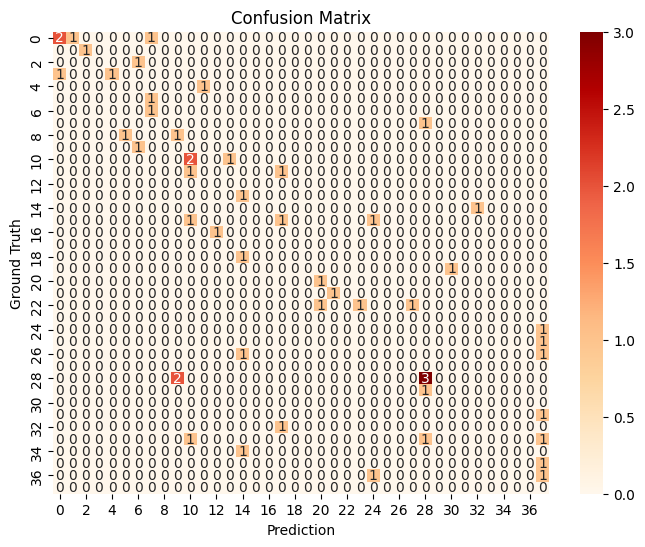

[4. 1. 1. 2. 1. 1. 1. 1. 2. 1. 3. 2. 0. 1. 1. 3. 1. 0. 1. 1. 1. 1. 3. 0.
 0. 0. 1. 1. 2. 0. 5. 1. 0. 1. 1. 3. 0. 1. 1. 2. 0.]


In [ ]:
test('/content/drive/MyDrive/paper/0415/0415-2/normalized.csv', test_model, 1)

26 21
22 23
22 29
22 41
41 41
38 36
20 36
16 16
15 11
15 11
13 12
14 18
18 36
30 36
33 31
33 31
31 6
1 1
1 1
1 5
1 10
6 31
28 35
24 36
27 18
15 11
11 11
11 12
27 18
15 36
20 38
1 41
1 30
22 24
22 21
22 21
22 26
30 41
30 41
30 36
20 36
23 17
36 11
11 11
11 15
15 20
20 36
33 32
33 31
9 6
9 1
1 1
22 4
22 10
33 31
33 36
16 41
40 30
30 23
Mean Distance Error: 2.434892827280749
Testing Loss: nan
Testing Accuracy: 0.1186


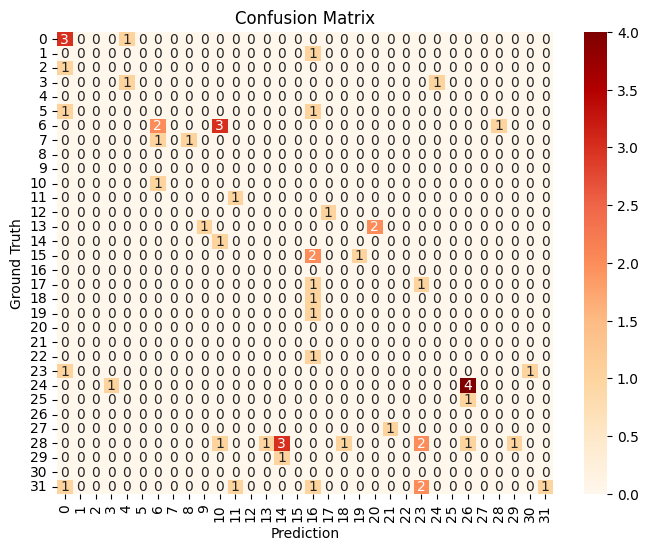

[ 4.  0.  0.  1.  1.  2.  0.  0.  0.  2.  6.  2.  0.  0.  1.  1.  1.  3.
  0.  1.  3.  0.  2.  1.  0.  1.  0.  0.  1.  2.  5.  1.  0.  0.  1. 10.
  0.  1.  0.  0.  6.]


In [ ]:
test('/content/drive/MyDrive/paper/0422/0422-1/normalized.csv', test_model, 1)